# Dragging gestures: Analysis

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os, shutil
import sympy as sp

# before attemping to import these, two, make sure you upload them to the folder
# where this ipynb is located !!!!
import display_properties
import curve_functions

# for linear regression summary
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import normal_ad
from scipy.stats import shapiro as normal_shapiro

Screen X Size: 13.596578379142969
Screen Y Size: 7.64807533826792
FIgure DPI 141.21199808219862
Cartesian Unit len (inches) 1.6801605376106268
Cartesian Unit len (cm) 4.267607765530992
Polar Unit len (inches) 1.529615067653584
Polar Unit len (cm) 3.8852222718401035
Linewidth in inches: 0.013888888888888888
Linewidth in centimeters: 0.035277777777777776


In [2]:
iodModelName = 'length:w'
# iodModelName = 'kappa'
# iodModelName = 'length'
centralTendency = 'mean'
# centralTendency = 'median'

funcIoDs = {
    #'kappa*length': json.load(open('index_of_difficulty-kappa*length.json')),
    'length': json.load(open('index_of_difficulty-' + 'length' +'.json')),
    'kappa': json.load(open('index_of_difficulty-' + 'kappa' +'.json')),
    #'log(kappa+length)': json.load(open('index_of_difficulty-log(kappa+length).json')),
    'log(length:alpha+kappa+1)': json.load(open('index_of_difficulty-log(length:alpha+kappa+1).json')),
    'length:w+kappa': json.load(open('index_of_difficulty-length:alpha+kappa.json')),
    'length:w': json.load(open('index_of_difficulty-length:alpha.json')),
    # 'w': json.load(open('index_of_difficulty-w.json')),
}

In [3]:
# prepare folders and erase all figures
# only remove folders which are going to be changed by executing this script

figuresFoldername = 'figures'
drawingTimeHistogramsFoldername = 'drawing_time_histograms'
linearRegressionFoldername = 'linear_regressions'
takeScreenshots = True
useCroatian = True

drawingTimeHistogramsFolderPath = figuresFoldername + "/" + drawingTimeHistogramsFoldername + "/"
linearRegressionsFolderPath = figuresFoldername + "/" + linearRegressionFoldername \
    + "/" + iodModelName \
    + "/" + centralTendency + "/"
participantDataFolderPath = figuresFoldername + "/participants/"

def saveFigure(figurename):
    figurename = figurename.replace(' ', '_').replace('\n', '')
    if(takeScreenshots is True):
        plt.savefig(figurename)

def resetFigureFolder(foldername):
    if(os.path.exists(foldername)):
        shutil.rmtree(foldername)
    os.makedirs(foldername)

if(takeScreenshots is True):
    foldersToBeChanged = [
        drawingTimeHistogramsFolderPath,
        linearRegressionsFolderPath,
        participantDataFolderPath
    ]
    
    for foldername in foldersToBeChanged:
        print(foldername)
        resetFigureFolder(foldername)    

def translateWord(word):
    retval = ""
    if(word == "Cartesian"):
        retval = "Kartezijev"
    elif(word == "Polar"):
        retval = "Polarni"
    elif word == "Mouse":
        retval = "Miš"
    elif word == "Graphic tablet":
        retval = "Grafički tablet"
    elif word == "median":
        retval = "medijan"
    elif word == "mean":
        retval = "Arit.sred."
    else:
        retval = word + " - neprevedeno"
    return retval
        
def translate(words):
    if(useCroatian is False):
        return words
    
    if(type(words) is not list):
        return translateWord(words)
    
    retval = []
    for word in words:
            retval.append(translateWord(word))
    return retval

figures/drawing_time_histograms/
figures/linear_regressions/length:w/mean/
figures/participants/


In [4]:
df = pd.read_csv('logs.csv')

print("Columns:", df.columns)
# indices of important columns
prAgeInd = 1
deviceInd = 2
testModeInd = 3
funcIdInd = 5
funcDiffInd = 6
funcProjInd = 7
drawTimeInd = 8

test0data = df[df['Test mode'] == 0]
test1data = df[df['Test mode'] == 1]

PROJECTIONS = ['Cartesian', 'Polar']
FUNC_IDS = [0, 1, 2, 3, 4, 5]
DEVICES = ['Mouse', 'Graphic tablet']
TEST_MODES = [0, 1]

def getIodForFunc(projection, experimentMode, funcId, iodName=iodModelName):
    test = 0
    if projection == 'Cartesian' and experimentMode == 1:
        test = 1
    elif projection == 'Polar' and experimentMode == 0:
        test = 2
    elif projection == 'Polar' and experimentMode == 1:
        test = 3
    # retval = np.log2(2 * float(funcIoDs[iodName][str(test)][str(funcId)]))
    retval = float(funcIoDs[iodName][str(test)][str(funcId)])
    return retval

def getIodsAsArray(projections, experimentModes, iodName=iodModelName):
    iodsArr = []
    for experimentMode in experimentModes:
        for projection in projections:            
            for funcId in FUNC_IDS:
                iodsArr.append(getIodForFunc(projection, experimentMode, funcId, iodName))
    return iodsArr

def getMaxIodForPlot(iodName=iodModelName):
    return round(max(getIodsAsArray(PROJECTIONS, TEST_MODES, iodName))) * 1.2

print(getIodForFunc("Polar", 1, 0))


# Anderson-Darling test for normal distribution unknown mean and variance.
# Or shapiro-wilk
def isDataNormallyDistributed(data, p_value_thresh=0.05):
    p_value = normal_shapiro(data)[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Data is not normally distributed')
    else:
        print('Data is normally distributed')
    return p_value

Columns: Index(['Participant name', 'Participant age', 'Participant handedness',
       'Device', 'Test mode', 'Logging timestamp', 'Function ID',
       'Function difficulty', 'Function projection', 'Drawing time',
       'Error approx', 'Expert Mouse User', 'Expert Graphic Tablet User'],
      dtype='object')
11.619674499413847


# Drawing time distribution per function

In [5]:
def getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data=df):
    # filter out by projection, Cartesian or Polar
    drawingTimes = data[data['Function projection'] == projection]
    # filter out by function ID
    drawingTimes = drawingTimes[drawingTimes['Function ID'] == funcId]
    # filter out by test (experiment mode)
    drawingTimes = drawingTimes[drawingTimes['Test mode'] == experimentMode]
    # filter out by device
    drawingTimes = drawingTimes[drawingTimes['Device'] == device]
    
    # for each user, find his/her average for this function
    participants = list(set(drawingTimes["Participant name"]))
    # find average of each participant for this function
    retval = []
    for participant in participants:
        dataForParticipant = drawingTimes[drawingTimes["Participant name"] == participant]
        avg = np.mean(dataForParticipant["Drawing time"].values)
        retval.append(avg)
        
    # return this to return ALL drawing times, without calculating mean for each participant
    return retval

projection = "Polar"
funcId = 0
device = "Mouse"
experimentMode = 0


def plotDrawingTimesDistributionsForEachFunc():
    for experimentMode in TEST_MODES:
        for projection in PROJECTIONS:
            for device in DEVICES:
                for funcId in FUNC_IDS:
                    dts = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode)

                    plt.figure()
                    plt.hist(dts, color="teal", bins=15)
                    # limits are hard-coded, if I ever have time, I will make the limits calculation smarter
                    xlim = [0, 15]
                    ylim = [0, 75]
                    plt.ylim(xlim)
                    plt.xlim(ylim)

                    # add text with Median an Mean displayed
                    text = "Median: %.3f, Mean: %.3f" % (np.median(dts), np.mean(dts))
                    plt.text(ylim[1]-1, xlim[1]-1, text, ha='right', va='top', bbox=dict(facecolor='white', alpha=1))

                    plt.title(
                        "Mode: %s, Projection: %s, Device: %s, Function: %s"
                         % (experimentMode, translate(projection), translate(device), funcId)
                    )
                    plt.ylabel("Count")
                    plt.xlabel("Drawing time [seconds]")
                    saveFigure(
                        drawingTimeHistogramsFolderPath \
                        + "mode-" + str(experimentMode) \
                        + "_device-" + device + \
                        "_function-" + str(funcId) +".png"
                    )
                    plt.show()
                    print("Mean: ", np.mean(dts))
                    print("Median: ", np.median(dts))
                    print("IOD: ", getIodForFunc(projection, experimentMode, funcId))
                    
                    
# plotDrawingTimesDistributionsForEachFunc()

# Average drawing time for each curve on each input device

In [6]:
def getAvgForFunc(projection, funcId, device, experimentMode = 0, data=df):
    drawingTimes = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
    
    avg = np.mean(drawingTimes) if centralTendency=='mean' else np.median(drawingTimes)
    
    return avg #* 1000 # transform to milliseconds

def getAvgsByFilter(projections, funcIds, devices, experimentModes, iodName=iodModelName, data=df):
    times = []
    iods = []
    for experimentMode in experimentModes:
        for device in devices:
            for projection in projections:
                for funcId in funcIds:
                    avg = getAvgForFunc(projection, funcId, device, experimentMode, data=data)
                    times.append(avg)
                    iods.append(getIodForFunc(projection, experimentMode, funcId, iodName))
                    # use this if you want to get ALL drawing times paired with iods
                    # avg = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
                    # times.extend(avg)
                    # iods.extend([getIodForFunc(projection, experimentMode, funcId)] * len(avg))                
    return times, iods

MAX_AVG_DRAW_TIME = round(max(getAvgsByFilter(PROJECTIONS, FUNC_IDS, DEVICES, TEST_MODES)[0]))
MIN_AVG_DRAW_TIME = round(min(getAvgsByFilter(PROJECTIONS, FUNC_IDS, DEVICES, TEST_MODES)[0]))
MAX_AVG_DRAW_TIME += 0.2 * MAX_AVG_DRAW_TIME
MIN_AVG_DRAW_TIME -= 0.2 * MIN_AVG_DRAW_TIME

# for mode in TEST_MODES:
#    print("----------------- MODE:", mode)
#    for device in DEVICES:
#        print(":::", device, ":::")
#        for funcId in FUNC_IDS:
#            print("--> Function: ", funcId)
#            for projection in PROJECTIONS:
#                avg = getAvgForFunc(projection, funcId, device, mode)
#                print("\t", projection, ": ", avg)


# Test plots

In [7]:
def plotForExperiment(experimentModes, projections = PROJECTIONS):
    for experimentMode in experimentModes:
        for device in DEVICES:
            plt.figure()
            for projection in projections: 
                times = []
                for funcId in funcIds:
                    times.append(getAvgForFunc(projection, funcId, device, experimentMode))

                iods = (getIodsAsArray([projection], [experimentMode]))
                plt.scatter(iods, times, label=projection)


            plt.ylabel("Drawing time (s)")
            plt.xlabel("Index of difficulty")
            plt.ylim([0, MAX_AVG_DRAW_TIME])
            plt.xlim([0, getMaxIodForPlot()])
            plt.legend(loc='upper left')
            plt.title("Experiment %d, %s, %s" %(experimentMode, device, projections) )
            
            plt.show()

## Test plots

In [8]:
# plotForExperiment([0, 1])

# Linear regression

In [9]:
plotTextSize = 18
def calculateResiduals(model, x, y):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(x)
    residuals = abs(y) - abs(predictions)
    return residuals, predictions


def checkLinearAssumption(model, x, y, axes):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    residuals, predictions = calculateResiduals(model, x, y)
            
    # Plotting the diagonal line
    lineCoords = np.arange(MIN_AVG_DRAW_TIME, MAX_AVG_DRAW_TIME)
    axes.plot(lineCoords, lineCoords, color="black")
    
    for actual_y, predicted_y in zip(y, predictions):
        axes.plot([predicted_y, predicted_y], [predicted_y, actual_y], color="darkgrey")
        pass
    
    # Plotting the actual vs predicted values
    axes.scatter(x=predictions, y=y, color="coral", edgecolors="grey")
    axes.axis("equal")
    axes.set_title("Actual vs Predicted")
    axes.set_ylabel("Actual")
    axes.set_xlabel("Predicted")
    axes.tick_params(axis='both', labelsize=plotTextSize)
    
    if useCroatian is True:
        axes.set_title("Stvarne vs. predviđene vrijednosti", fontsize=plotTextSize)
        axes.set_ylabel("Stvarno [s]", fontsize=plotTextSize)
        axes.set_xlabel("Predviđeno [s]", fontsize=plotTextSize)
    
    axes.grid(True)
    
    mspe, rmspe = getMseAndRmspe(model, x, y)
    axesText = 'MSE = %.3f\nRMSPE = %.3f%%' % (mspe, rmspe) 
    axes.text(MIN_AVG_DRAW_TIME * 1.05, MAX_AVG_DRAW_TIME * 0.95,
             axesText,
             size=plotTextSize,
             ha='left', va='top',
             bbox=dict(facecolor='white', alpha=1)
    )
    axes.set_ylim([MIN_AVG_DRAW_TIME, MAX_AVG_DRAW_TIME])
    axes.set_xlim([MIN_AVG_DRAW_TIME, MAX_AVG_DRAW_TIME])
    return axes

def normalErrorsAssumption(model, x, y, axes, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    residuals, predictions = calculateResiduals(model, x, y)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    # p_value = normal_ad(residuals)[1]
    p_value = isDataNormallyDistributed(residuals)
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    axes.set_title('Distribution of Residuals', fontsize=plotTextSize)
    if useCroatian is True:
        axes.set_title('Histogram reziduala', fontsize=plotTextSize)
    axes.set_ylabel('Broj', fontsize=plotTextSize)
    axes.tick_params(axis='both', labelsize=plotTextSize)
    sns.histplot(residuals, ax=axes)
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

        
def multicollinearityAssumption(model, x, y, axes, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    sns.heatmap(pd.DataFrame(x, columns=feature_names).corr(), annot=True, ax=axes)
    axes.set_title('Correlation of Variables')
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(x.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

        
def autocorrelationAssumption(model, x, y):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    residuals, predictions = calculateResiduals(model, x, y)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(residuals)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

def homoscedasticityAssumption(model, x, y, axes):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    residuals, predictions = calculateResiduals(model, x, y)

    # Plotting the residuals
    indices = np.arange(0, len(residuals))
    axes.scatter(x=indices, y=residuals, alpha=0.5)
    axes.plot(np.repeat(0, np.max(indices) + 1), color='darkorange', linestyle='--')
    axes.set_title('Residuals', fontsize=plotTextSize)
    axes.tick_params(axis='both', labelsize=plotTextSize)
    axes.set_ylim([-5, 5])
    
    if useCroatian is True:
        axes.set_title('Reziduali', fontsize=plotTextSize)
        

    
def testRegressionAssumptions(reg, x, y, title):
    # plot the linearity assumption separately
    figure, axes = plt.subplots(1)
    figure.set_size_inches(6, 6)
    checkLinearAssumption(reg, x, y, axes)
    saveFigure(linearRegressionsFolderPath + "_assumptions_linearity_" + title.replace(' ', '_').replace('\n', ''))
    plt.close(figure)
    
    figure, axes = plt.subplots(1, 2)
    figure.set_size_inches(12, 6)
    normalErrorsAssumption(reg, x, y, axes[0])
    # multicollinearityAssumption(reg, x, y, axes[1, 0])
    autocorrelationAssumption(reg, x, y)
    homoscedasticityAssumption(reg, x, y, axes[1])
    
    # st = figure.suptitle(title)
    st = figure.suptitle('')
    figure.tight_layout(pad=2)
    # shift subplots down:
    st.set_y(1)
    figure.subplots_adjust(top=0.85)
    
    saveFigure(linearRegressionsFolderPath + "_assumptions_residuals_" + title.replace(' ', '_').replace('\n', ''))
    plt.close(figure)


def getBasePlotTitle(projections, device, experimentModes):
    if useCroatian is True:
        return "Linearna regresija za %s sustav, %s, \nIndeks težine = %s, faza = %s" \
                       %(translate(projections), translate(device), iodModelName, experimentModes[0] + 1)
        
        
    return "Linear regression for %s, %s, mode=%s,\nCentral Tendency=%s,Index Of Difficulty=%s" \
                   %(projections, device, experimentModes, centralTendency, iodModelName)

def getRegressionCoefficients(reg):
    x1 = 0
    x2 = 1
    y1, y2 = reg.predict(np.array([[x1], [x2]]))
    # Coefficients: y = ax + b
    b = y1
    a = (y2 - y1) / (x2 - x1)
    return a, b

# get x and y data for linear regression
def getDataForRegression(projections, experimentModes, device):
    y, iods = np.array(getAvgsByFilter(projections, FUNC_IDS, [device], experimentModes))
    x = [[iod] for iod in iods]
    return x, y

def getMseAndRmspe(reg, x, y):
    y_predicted = reg.predict(x)
    mse = metrics.mean_squared_error(y_predicted, y)
    rmspe = (np.sqrt(np.mean(np.square((y_predicted - y) / y_predicted)))) * 100
    return mse, rmspe

def getFormattedRegressionMetrics(reg, x, y):
    a, b = getRegressionCoefficients(reg)
    y_predicted = reg.predict(x)
    mse, rmspe = getMseAndRmspe(reg, x, y)
    print(rmspe)
    return 'MT = %.3fx + %.3f\nR^2 = %.3f\nMSE = %.3f\nRMSPE = %.3f%%' % (a, b, reg.score(x, y), np.sqrt(mse), rmspe)

# model metrics :: for evaulating the regression model
def printRegressionModelMetrics(reg, x, y):
    print(getFormattedRegressionMetrics(reg, x, y))

# training and retrieving the model 
def getRegressionModel(projections, experimentModes, device, axes):
    x, y = getDataForRegression(projections, experimentModes, device)
    reg = LinearRegression().fit(x, y)
    title = getBasePlotTitle(projections, device, experimentModes)
    plotDataAndReg(reg, x, y, title, axes)
    printRegressionModelMetrics(reg, x, y)
    testRegressionAssumptions(reg, x, y, title)

    return reg

def plotDataAndReg(reg, x, y, title, axes):
    MAX_IOD = getMaxIodForPlot()

    predictX = np.linspace(0, MAX_IOD, 10)
    predictY = reg.predict([[x] for x in predictX])
    
    axes.plot(predictX, predictY, color="black")
    axes.scatter(x, y, color="turquoise", edgecolors="navy",)
    
    axes.set_ylabel("Drawing time [s]", fontsize=plotTextSize)
    axes.set_xlabel("Index of difficulty", fontsize=plotTextSize)
    
    axes.tick_params(axis='both', labelsize=plotTextSize)
    
    if useCroatian is True:
        axes.set_ylabel("Vrijeme crtanja [s]", fontsize=plotTextSize)
        axes.set_xlabel("Indeks težine [bit]", fontsize=plotTextSize)        
    
    axes.set_ylim([0, MAX_AVG_DRAW_TIME])
    axes.set_xlim([0, MAX_IOD])
    axes.grid(True)
    axes.set_title(title, fontsize=plotTextSize * 1.1)
    # axes.axis('scaled')
    
    a, b = getRegressionCoefficients(reg)
    axesText = 'MT = %.3f + %.3f ID\nR^2 = %.3f' % (b, a, reg.score(x, y))
    axes.text(MAX_IOD * 0.05, MAX_AVG_DRAW_TIME * 0.95,
             axesText,
             size=plotTextSize * 1.1,
             ha='left', va='top',
             bbox=dict(facecolor='white', alpha=1)
    )
    

def validateRegressionModel(reg, projections, experimentModes, device, axes):  
    x, y = getDataForRegression(projections, experimentModes, device)
    title = getBasePlotTitle(projections, device, experimentModes)
    
    testRegressionAssumptions(reg, x, y, title)
    plotDataAndReg(reg, x, y, title, axes)
    printRegressionModelMetrics(reg, x, y)
    
    
def trainRegressionModelThenValidate(projections, device):
    print("\n\nSKLEARN")
    MAX_IOD = getMaxIodForPlot()
    (width, height) = 12, 5

    figure, axes = plt.subplots(1)
    figure.set_size_inches(width, height)
    
    reg = getRegressionModel(projections, [0], device, axes)
    axes.set_title('') # remove the default title
    title = getBasePlotTitle(projections, device, [0])
    saveFigure(linearRegressionsFolderPath + title.replace(' ', '_').replace('\n', ''))
    plt.show(figure)
    
    figure, axes = plt.subplots(1)
    figure.set_size_inches(width, height)
 
    validateRegressionModel(reg, projections, [1], device, axes)
    axes.set_title('') # remove the default title

    # figure.tight_layout(pad=2)

    title = getBasePlotTitle(projections, device, [1])
    saveFigure(linearRegressionsFolderPath + title.replace(' ', '_').replace('\n', ''))
    
    plt.show(figure)
    
    # print("\n\nSTATSMODELS")
    # x, y = getDataForRegression(projections, [0], device)
    # constx = sm.add_constant(x)
    # reg = sm.OLS(y, constx).fit()
    # print(reg.summary())
    



SKLEARN
7.877184405968513
MT = 3.223x + -10.896
R^2 = 0.958
MSE = 1.771
RMSPE = 7.877%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.23904992640018463
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.23904992640018463
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.3382222355136304
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity

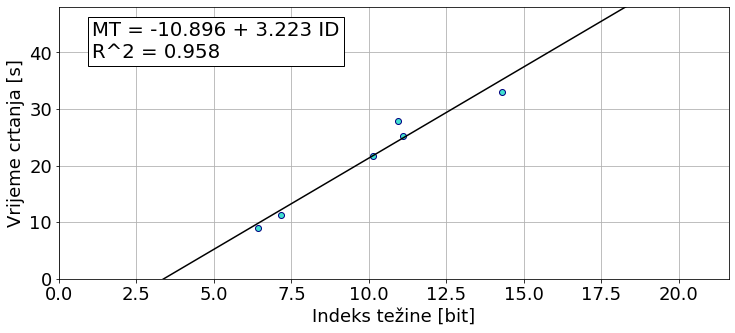

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.13422243297100067
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.13422243297100067
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.3112453315274495
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
10.62256716045434
MT =

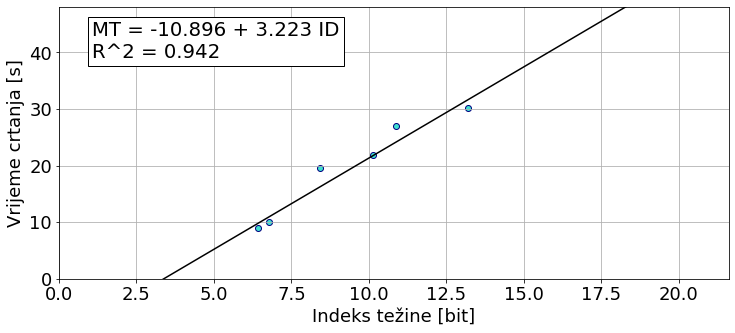



SKLEARN
9.95088171258419
MT = 2.982x + -8.507
R^2 = 0.924
MSE = 2.254
RMSPE = 9.951%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.14959396421909332
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.14959396421909332
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.413599492119951
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of

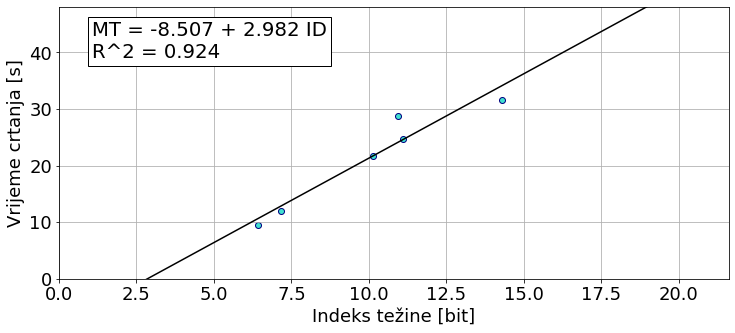

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.36450475454330444
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.36450475454330444
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 0.4934614317751677
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
17.1185576006

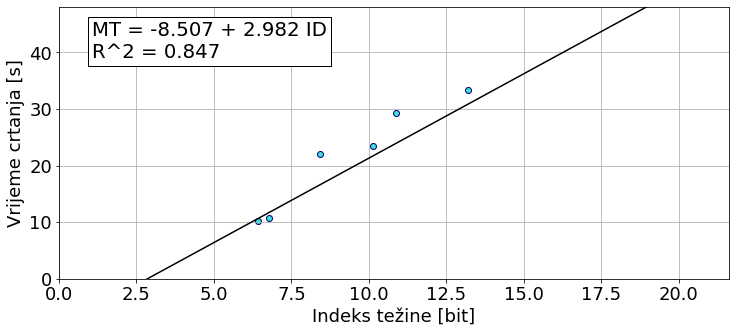



SKLEARN
9.697967504708584
MT = 2.993x + -12.061
R^2 = 0.917
MSE = 2.307
RMSPE = 9.698%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.13880543410778046
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.13880543410778046
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.42187988431745
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homosceda

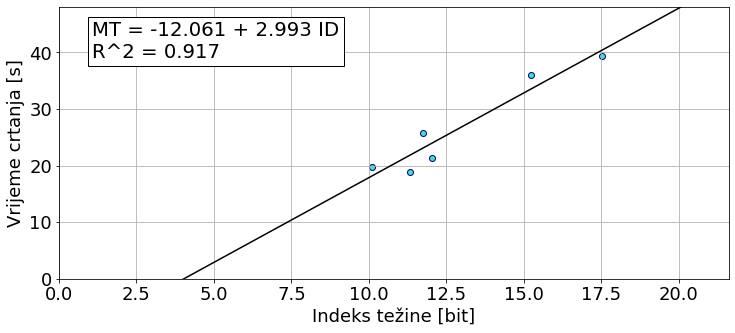

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.47622764110565186
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.47622764110565186
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9367411300081452
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
10.632552146686136
MT 

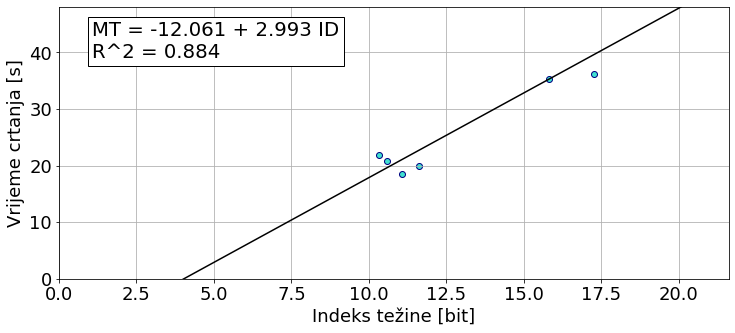



SKLEARN
10.207524600736404
MT = 2.775x + -8.876
R^2 = 0.888
MSE = 2.520
RMSPE = 10.208%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.5363209843635559
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.5363209843635559
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.7117095322131906
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity 

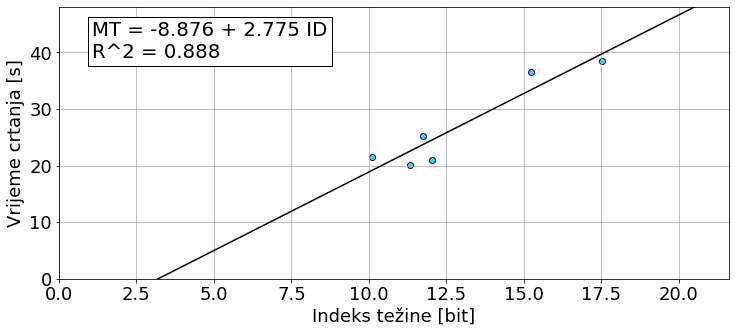

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.6944628357887268
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.6944628357887268
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 0.7151601300249996
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
11.956854524079

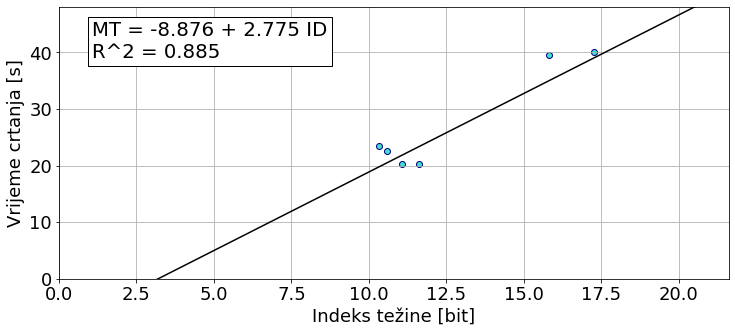



SKLEARN
11.422614774234782
MT = 2.794x + -8.037
R^2 = 0.908
MSE = 2.654
RMSPE = 11.423%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.6527811884880066
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.6527811884880066
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.1839230166323091
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homosced

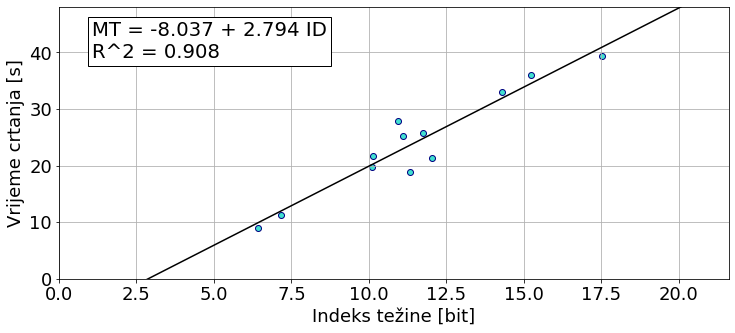

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.3524245619773865
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.3524245619773865
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.635377909792931
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
13.415675829889363
MT = 2

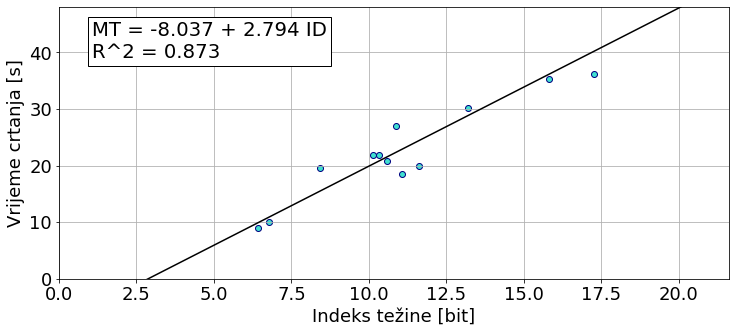



SKLEARN
11.563873644655809
MT = 2.651x + -6.231
R^2 = 0.897
MSE = 2.688
RMSPE = 11.564%
Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9192759990692139
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.9192759990692139
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.4928536433677138
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homosced

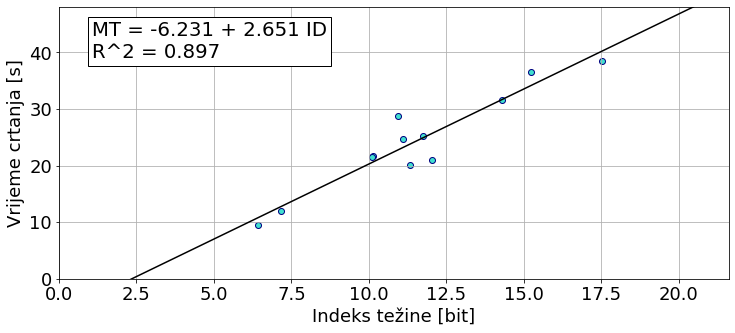

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9606704711914062
Data is normally distributed
p-value from the test - below 0.05 generally means non-normal: 0.9606704711914062
Residuals are normally distributed

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.12694298291723
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance
17.01567658779680

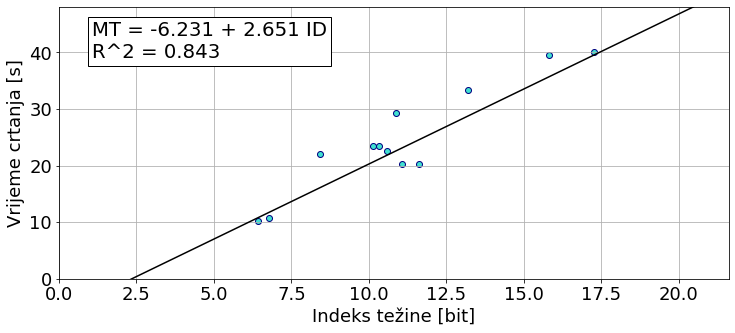

In [10]:
for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
    for device in DEVICES:
        trainRegressionModelThenValidate(projections, device)
        
        
        #reg2 = getRegressionModel(projections, [0, 1], device)
        # test the residuals as shown here: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

# Participant data

Number of participants: 24
Average participant age: 23.542
Standard deviation: 1.154

 ::::
Number of Left-handed participants: 3
Percentage of Left-handed participants 12.5 %
Number of Right-handed participants: 21
Percentage of Right-handed participants 87.5 %
Number of Ambidextrous participants: 0
Percentage of Ambidextrous participants 0.0 %

 ::::
Number of expert graphic tablet participants: 1
Percentage of expert graphic tablet participants 4.2 %
Number of expert mouse participants: 24
Percentage of expert graphic tablet participants 100.0 %

 ::::
Average drawing times
Participant;Device;Projections;Drawing Time Mean;Drawing time stdev
p-value from the test - below 0.05 generally means non-normal: 0.029293866828083992
Data is not normally distributed



Participant;Device;Projections;Drawing Time Mean;Drawing time stdev
p-value from the test - below 0.05 generally means non-normal: 0.05171981081366539
Data is normally distributed



Participant;Device;Projections;Drawing Time M

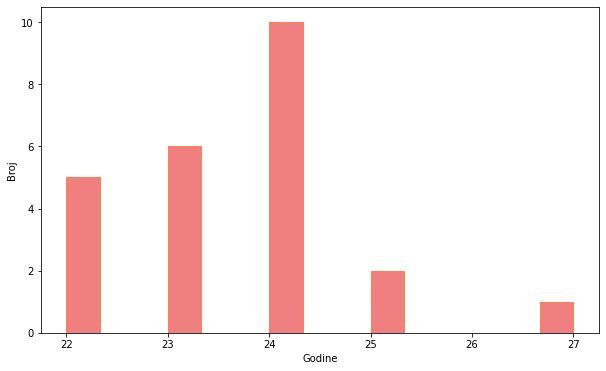

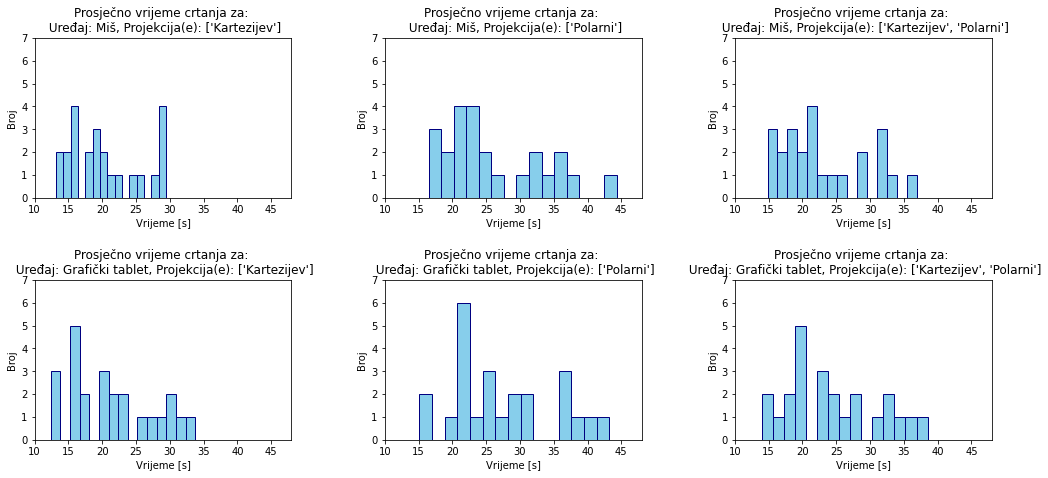

In [19]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
handednessFreq = {
    "Left-handed": 0,
    "Right-handed": 0,
    "Ambidextrous": 0
}
hasExpWTablet = 0
hasExpWMouse = 0
for participant in participants:
    row = df[df['Participant name'] == participant]
    age = row['Participant age'].values[0]
    handednessFreq[row['Participant handedness'].values[0]] += 1
    hasExpWTablet += row['Expert Graphic Tablet User'].values[0]
    hasExpWMouse += row['Expert Mouse User'].values[0]
    # print(participant, age)
    ages.append(age)

plt.figure(figsize=(10,6))
plt.hist(ages, color="lightcoral", bins=15, edgecolor="coral")
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
if useCroatian is True:    
    plt.ylabel("Broj")
    plt.xlabel("Godine")
    plt.title("")
    # plt.title("Starosna distribucija ispitanika")
saveFigure(participantDataFolderPath + "participant_age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))
print("Standard deviation:", round(np.std(ages), 3))

print("\n ::::")

for handedness in handednessFreq:
    freq = handednessFreq[handedness]
    print("Number of " + handedness + " participants:", freq)
    print("Percentage of " + handedness + " participants", round(freq * 1.0 / len(participants), 3)*100, '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3)*100, '%'
)

print("Number of expert mouse participants:", hasExpWMouse)
print("Percentage of expert graphic tablet participants",
      round(hasExpWMouse * 1.0 / len(participants), 3)*100, '%'
)

print("\n ::::")
print("Average drawing times")


# separator is semicolon because the 'projections' column has commas in it
separator = ';'

# Average drawing time per user
sortedParticipants = sorted(participants)
figure, axes = plt.subplots(len(DEVICES), len([["Cartesian"], ["Polar"], PROJECTIONS]))
figure.set_size_inches(15, 7)

for k, device in enumerate(DEVICES):
    for j, projections in enumerate([["Cartesian"], ["Polar"], PROJECTIONS]):
        pltData = []
        print("Participant","Device", "Projections","Drawing Time Mean", "Drawing time stdev", sep=separator)
        for i in range(len(sortedParticipants)):
            participant = sortedParticipants[i]
            dts = []
            for funcId in FUNC_IDS:
                for experimentMode in TEST_MODES:
                    drawingTimes = df[df['Participant name'] == participant]
                    drawingTimes, _ = getAvgsByFilter(projections, [funcId], [device], [experimentMode], data=drawingTimes)
                    dts.append(drawingTimes)
            # print(participant, device, projections, round(np.mean(dts), 4), round(np.std(dts), 4), sep=separator)
            pltData.append(np.mean(dts))
        # print()
        ax = axes[k][j]
        ax.hist(pltData, color='skyblue', bins=15, edgecolor="navy")

        pValueNormDist = isDataNormallyDistributed(np.array(pltData))
        
        title = "Average drawing time for \n Device %s, Projection(s) %s" %(device, projections)
        ax.set_ylabel("Count")
        ax.set_xlabel("Average drawing time [seconds]\nNorm dist p_value=%.5f" % (pValueNormDist))
        
        if useCroatian is True:
            title = "Prosječno vrijeme crtanja za: \n Uređaj: %s, Projekcija(e): %s" %(translate(device), 
                                                                                   translate(projections))
            ax.set_ylabel("Broj")
            ax.set_xlabel("Vrijeme [s]") #"\nNorm dist p_value=%.5f" % (pValueNormDist))
        ax.set_title(title)
        
        # this lim is hard-coded. if I ever have time, I should make this soft-coded :)
        ax.set_ylim([0, 7])
        ax.set_xlim([10, MAX_AVG_DRAW_TIME])
        print("\n\n")

figure.tight_layout(pad=2)
saveFigure(participantDataFolderPath + "Average_drawing_times")
plt.show()
            


## Error approximation

In [12]:
sortedParticipants = sorted(participants)
"""
# PLEASE NOTE, this is not correct. The error rate which was calculated in the "Throughput calculation"
# part is the one that /is/ correct.

print("Participant index", "Mouse error mean", "Mouse error stdev", "Graphic tablet error mean", "Graphic tablet error stdev", sep=separator)
avgs = { "Mouse":[], "Graphic tablet":[]}
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    print(participant, end='')
    for device in DEVICES:
        # epm = error per move
        epms = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            for file in files:
                funcId = int(file[3])
                projtmp = file[10]
                projection = "Cartesian"
                if(projtmp in ["2", "3"]):
                    projection = "Polar"
                # filter out by projection, Cartesian or Polar
                errors = df[df['Function projection'] == projection]
                # filter out by function ID
                errors = errors[errors['Function ID'] == funcId]
                # filter out by test (experiment mode)
                errors = errors[errors['Test mode'] == experimentMode]
                errors = errors[errors['Participant name'] == participant]
                # filter out by device
                errors = errors[errors['Device'] == device]
                f = open(filename + "/" + file)
                                
                # NOTE: This formula is not really correct. Check "Throughput calculation" for the right one.
                errorVal = np.mean(errors["Error approx"].values) * 1.0 / len(f.readlines())
                
                epms.append(errorVal)
                f.close()
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        print('', round(np.mean(epms), 6), round(np.std(epms), 6), sep=separator, end='')
        avgs[device].append(np.mean(epms))
    print()
"""

'\n# PLEASE NOTE, this is not correct. The error rate which was calculated in the "Throughput calculation"\n# part is the one that /is/ correct.\n\nprint("Participant index", "Mouse error mean", "Mouse error stdev", "Graphic tablet error mean", "Graphic tablet error stdev", sep=separator)\navgs = { "Mouse":[], "Graphic tablet":[]}\nfor i in range(len(sortedParticipants)):\n    participant = sortedParticipants[i]\n    print(participant, end=\'\')\n    for device in DEVICES:\n        # epm = error per move\n        epms = []\n        for experimentMode in TEST_MODES:\n            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)\n            files = os.listdir(filename)\n            for file in files:\n                funcId = int(file[3])\n                projtmp = file[10]\n                projection = "Cartesian"\n                if(projtmp in ["2", "3"]):\n                    projection = "Polar"\n                # filter out by projection, Cartesian or Po

In [13]:
"""
maxAvg = np.max([np.max(avgs["Mouse"]), np.max(avgs["Graphic tablet"])])
minAvg = np.min([np.min(avgs["Mouse"]), np.min(avgs["Graphic tablet"])])
xlim = [minAvg - 0.005, maxAvg + 0.005]
    
figure, (ax1, ax2) = plt.subplots(2)
figure.set_size_inches(5, 8)
ax1.hist(avgs["Mouse"], color="lightcoral", bins=15, edgecolor="black")

pValueNormDist = isDataNormallyDistributed(np.array(avgs["Mouse"]))

title = "Average error rate distribution, Mouse"
ax1.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))
ax1.set_ylabel("Participant count")

if useCroatian is True:
    title = "Distrubucija prosječne pogreške, Miš"
    ax1.set_xlabel("Iznos pogreške")
    ax1.set_ylabel("Broj ispitanika")
    
ax1.set_title(title)
ax1.set_ylim([0, 6])
ax1.set_xlim(xlim)

ax2.hist(avgs["Graphic tablet"], color="lightcoral", bins=15, edgecolor="black")

pValueNormDist = isDataNormallyDistributed(np.array(avgs["Graphic tablet"]))

title = "Average error rate distribution, Graphic tablet"

ax2.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))
ax2.set_ylabel("Participant count")
if useCroatian is True:
    title = "Distribucija prosječne pogreške, Grafički tablet"
    ax2.set_xlabel("Iznos pogreške")
    ax2.set_ylabel("Broj ispitanika")

ax2.set_title(title)
ax2.set_ylim([0, 6])
ax2.set_xlim(xlim)

figure.tight_layout(pad=2)
saveFigure(participantDataFolderPath + "Error_rates_dist")
plt.show()
"""

'\nmaxAvg = np.max([np.max(avgs["Mouse"]), np.max(avgs["Graphic tablet"])])\nminAvg = np.min([np.min(avgs["Mouse"]), np.min(avgs["Graphic tablet"])])\nxlim = [minAvg - 0.005, maxAvg + 0.005]\n    \nfigure, (ax1, ax2) = plt.subplots(2)\nfigure.set_size_inches(5, 8)\nax1.hist(avgs["Mouse"], color="lightcoral", bins=15, edgecolor="black")\n\npValueNormDist = isDataNormallyDistributed(np.array(avgs["Mouse"]))\n\ntitle = "Average error rate distribution, Mouse"\nax1.set_xlabel("Average error, Polar and Cartesian combined\nNorm dist p_value=%.5f" % (pValueNormDist))\nax1.set_ylabel("Participant count")\n\nif useCroatian is True:\n    title = "Distrubucija prosječne pogreške, Miš"\n    ax1.set_xlabel("Iznos pogreške")\n    ax1.set_ylabel("Broj ispitanika")\n    \nax1.set_title(title)\nax1.set_ylim([0, 6])\nax1.set_xlim(xlim)\n\nax2.hist(avgs["Graphic tablet"], color="lightcoral", bins=15, edgecolor="black")\n\npValueNormDist = isDataNormallyDistributed(np.array(avgs["Graphic tablet"]))\n\ntit

## Throughput calculation

In [14]:
sortedParticipants = sorted(participants)

fp = curve_functions.FunctionProvider()

x = sp.Symbol("x")

# array of ALL throughputs for mouse, i.e. TPs from ALL participants
allTPsForMouse = []
allTPsForGraphicTablet = []

## NOTE::: look in calculate_integrals.y
# this throughput calculation is not exactly correct :)
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    # print(participant, end='')
    # this will have two values; one for each device
    TPsForThisParticipant = {}
    
    for device in DEVICES:
        # the average throughput for this participant and this device
        # each user produces two throughputs: one for each device
        TPsForThisDevice = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            
            # each curve was passed through twice on each device,
            # so for example, curve with ID=1 and proj=2, was passed through twice on Mouse,
            # and then twice on graphic tablet.
            # We must find the average st dev for those two passes
            
            # 4= [0,1,2,3], testmode + projection combo
            errorStDevForFunc = np.zeros((len(FUNC_IDS), 4))
            
            for file in sorted(files):

                funcId = int(file[3])
                projtmp = file[10]
                # we are searching for an entry in the logs which can tell us
                # the average MT for user
                # and the st dev of error rate for user.
                # from the stdev of error rate, we will caluclate effective width of target (W_e)
                # and from that we'll get effective index of difficulty - ID_e
                # when we divide ID_e by the MT of the user, we get the user's throughput for a single curve
                # and then we find the mean of all throughputs for this user, which we
                # then use for t-test to compare the two pointing devices
                
                f = open(filename + "/" + file)
                    
                # find the stdev of the error by dividing the sum of errors with the square root of
                # the number of points (this is the stdev formula)
                pointsDrawn = [pointDrawn.replace('\n', '') for pointDrawn in f.readlines()]
                f.close()

                test = int(projtmp)        
                difficulty = int(int(funcId) / 2)
                task = int(funcId) % 2
                real_func = fp.provide_function(difficulty, task, test)
                real_func = sp.lambdify(x, real_func)

                # ALL of the error the user had made on this specific curve
                allErrorVals = []

                for pointDrawn in pointsDrawn:
                    x_coord = float(pointDrawn.split()[0])
                    y_coord = float(pointDrawn.split()[1])
                    real_y = real_func(x_coord)

                    y_diff = abs(y_coord - real_y)

                    if(projtmp in ["2", "3"]):
                        # polar projection, erroval should be multiplied with the polar unit length
                        # so that we get effective width in inches
                        y_diff *= display_properties.POLAR_UNIT_LENGTH_IN_INCH
                    else:
                        y_diff *= display_properties.CARTESIAN_UNIT_LENGTH_IN_INCH

                    allErrorVals.append(y_diff)
                # print(np.mean(allErrorVals), np.std(allErrorVals))
                errorVal = np.std(allErrorVals)
                # print(funcId, int(projtmp))
                errorStDevForFunc[funcId][int(projtmp)] += errorVal
            # print(errorStDevForFunc)
                
            for projtmp in [0, 1, 2, 3]:
                for funcId in FUNC_IDS: 
                    
                    projection = "Cartesian"
                    if(projtmp in [2, 3]):
                        projection="Polar"
                        
                    # filter out by projection, Cartesian or Polar
                    participantMovement = df[df['Function projection'] == projection]
                    # filter out by function ID
                    participantMovement = participantMovement[participantMovement['Function ID'] == funcId]
                    # filter out by test (experiment mode)
                    participantMovement = participantMovement[participantMovement['Test mode'] == experimentMode]
                    participantMovement = participantMovement[participantMovement['Participant name'] == participant]
                    # filter out by device
                    participantMovement = participantMovement[participantMovement['Device'] == device]
                    
                    # this is from the effective target width (Fitts law), a true-tried-tested formula
                    # we have to divide it by 2 because there are two passes through this curve
                    # and we're looking for the mean of the standard deviation
                    W_e = 4.133 * errorStDevForFunc[funcId][projtmp] / 2
                    if(W_e <= 0):
                        continue

                    # calculate effective ID_e for this W_e
                    kappa = getIodForFunc(projection, experimentMode, funcId, 'kappa')

                    length = getIodForFunc(projection, experimentMode, funcId, 'length')

                    # Id_e = np.log2(length / W_e + kappa + 1)
                    Id_e = length / W_e + kappa

                    # movement time
                    MT = np.mean(participantMovement["Drawing time"].values)

                    # throughput for this curve and this specific user
                    TP = Id_e / MT
                    TPsForThisDevice.append(TP)
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        # this is where the loop for each device ends --> we have to calculate
        # the avg throughput for this participant and this device

        TPsForThisParticipant[device] = np.mean(TPsForThisDevice)
    print(participant, TPsForThisParticipant["Mouse"], TPsForThisParticipant["Graphic tablet"], sep=separator)
    # 3/0
    allTPsForMouse.append(TPsForThisParticipant["Mouse"])
    allTPsForGraphicTablet.append(TPsForThisParticipant["Graphic tablet"])


Marin_Vidakovic_Lipovac;6.893770741342254;5.746212476321954
Mateja Napravnik;7.698892270167895;7.222730148487365
SadilaJeMare;7.119609723528754;7.126171069347014
Shanko;6.151394013510917;5.740316337722001
Vrtni_Patuljak;7.4966325065860575;5.029987923030343
Zmaj Zemun;7.375579928686576;6.693837334723983
aronta;7.735101690484785;6.197905562696868
asubasic;7.709266402047611;5.175842528085744
azahtila;6.286943357085427;6.405512478354603
bado97;5.371781717854307;3.8026713376830514
dgrdinic;8.452764174353879;7.06120816629646
dmakar;7.264167898513114;6.083235745138491
kfilipcic;6.001154418210748;6.24449609984391
kknezic;8.271679528472012;6.521622876173159
kskunca;5.335869331194495;4.397910801704107
lotovic;6.906281836739161;5.0025509341038505
mdudic;6.032370442208413;5.551723794922328
mduvnjak;5.983678402284885;4.894935064065073
mnjiric;8.288033847977635;8.044829866129435
mrGauss;9.013785297244299;7.21983883675036
mtvrdinic;7.141430455141815;6.364852201940676
rpolic;6.4910008936118;4.75526834

p-value from the test - below 0.05 generally means non-normal: 0.6534327864646912
Data is normally distributed


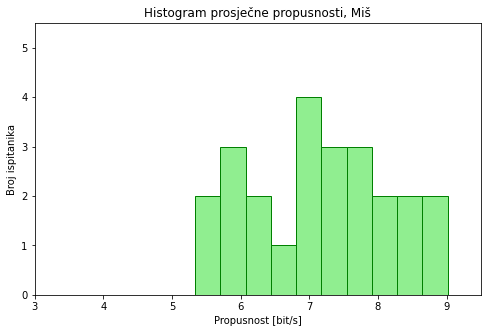

p-value from the test - below 0.05 generally means non-normal: 0.9470481872558594
Data is normally distributed


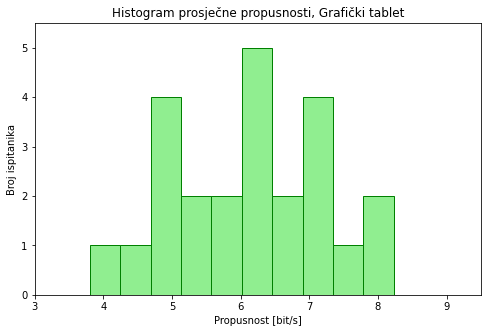

In [15]:
# now we should test whether the TPs are normally distributed

for i, tps in enumerate([allTPsForMouse, allTPsForGraphicTablet]):
    pValueNormDist = isDataNormallyDistributed(np.array(tps))
    device = DEVICES[i]
    
    plt.figure(figsize=(8,5))
    plt.hist(tps, color="lightgreen", edgecolor="green")
    title = "Average throughput distribution, " + device
    xlabel = "Average throughput, [bit/s]\nNorm dist p_value=%.5f" % (pValueNormDist)
    ylabel = "Participant count"

    if useCroatian is True:
        title = "Histogram prosječne propusnosti, " + translate(device)
        xlabel = "Propusnost [bit/s]"
        ylabel = "Broj ispitanika"

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # these limits are hard-coded, and they're here to make the histograms have the same x 
    # and y ranges on both plots
    plt.xlim([3, 9.5])
    plt.ylim([0, 5.5])
    
    saveFigure(participantDataFolderPath + "Throughput_dist" +  device)
    plt.show()
